<a href="https://colab.research.google.com/github/katterine2558/mri-tumor-detection-cnn/blob/main/mri_tumor_detection_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ==========================================================
# 🔧 CONFIGURACIÓN DE ENTORNO COLAB PRO (GPU + OPTIMIZACIONES)
# ==========================================================
import os, gc, psutil, tensorflow as tf
from tensorflow.keras import mixed_precision

# ----------------------------------------------------------
# 1️⃣ LIMPIEZA DE SESIÓN ANTERIOR
# ----------------------------------------------------------
gc.collect()
tf.keras.backend.clear_session()

# ----------------------------------------------------------
# 2️⃣ INFORMACIÓN DEL HARDWARE
# ----------------------------------------------------------
try:
    gpu_info = !nvidia-smi --query-gpu=name,memory.total --format=csv,noheader
    print("GPU detectada:", gpu_info[0])
except:
    print("No se detectó GPU, verifica que el acelerador esté activado en Entorno > Configuración de ejecución.")

# ----------------------------------------------------------
# 3️⃣ FORZAR USO DE GPU
# ----------------------------------------------------------
physical_gpus = tf.config.list_physical_devices('GPU')
if physical_gpus:
    print(f"TensorFlow detecta {len(physical_gpus)} GPU(s): {physical_gpus}")
    try:
        for gpu in physical_gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except:
        pass
else:
    print("No hay GPU activa, se usará CPU (entrenamiento más lento).")

# ----------------------------------------------------------
# 4️⃣ ACTIVAR ENTRENAMIENTO DE PRECISIÓN MIXTA (FLOAT16)
# ----------------------------------------------------------
mixed_precision.set_global_policy('mixed_float16')
print("Política de precisión:", mixed_precision.global_policy())

# ----------------------------------------------------------
# 6️⃣ MOSTRAR INFORMACIÓN DE RECURSOS
# ----------------------------------------------------------
print(f"Memoria RAM disponible: {psutil.virtual_memory().total / 1e9:.2f} GB")
print("Entorno configurado correctamente para máximo rendimiento.\n")

GPU detectada: NVIDIA A100-SXM4-80GB, 81920 MiB
TensorFlow detecta 1 GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Política de precisión: <DTypePolicy "mixed_float16">
Memoria RAM disponible: 179.37 GB
Entorno configurado correctamente para máximo rendimiento.



In [3]:
#==========================================================
# LIBRARIES
#==========================================================
from google.colab import files
#!pip install -q kaggle #Descomentar si no está instalado Kaggle en el entorno
import os
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
from collections import Counter
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Add, Activation,GlobalAveragePooling2D , Multiply, Reshape, DepthwiseConv2D, BatchNormalization ,GlobalAveragePooling2D, Resizing, Rescaling, RandomBrightness, RandomContrast, RandomRotation, RandomZoom, BatchNormalization, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import AUC
!pip install keras-tuner --upgrade
from keras_tuner.tuners import RandomSearch
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
!nvidia-smi

#Ruta base
base_dir = '/content/mri_data'
#Ruta para almacenar split
split_dir = "/content/mri_data_split"
#Semilla
seed = 0;
#Tamaño del batch
batch_size = 128
#Image size
image_size = (224, 224)

print("Dispositivo:", tf.config.list_physical_devices('GPU'))
mixed_precision.set_global_policy('mixed_float16')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.debugging.set_log_device_placement(False)

# Carpeta donde guardas los resultados
tuner_dir = "tuning_results"

# Elimina la carpeta completa si existe
if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 13.5 MB/s eta 0:00:00
Mon Nov  3 07:37:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   33C    P0             56W /  400W |       5MiB /  81920MiB |      0%      Default |
|                                         |                

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/rm1000/brain-tumor-mri-scans
License(s): CC0-1.0
 68% 160M/236M [00:00<00:00, 1.67GB/s]
100% 236M/236M [00:00<00:00, 1.68GB/s]
Categorías encontradas: ['meningioma', 'healthy', 'glioma', 'pituitary']
meningioma: 1645 imágenes
healthy: 2000 imágenes
glioma: 1621 imágenes
pituitary: 1757 imágenes


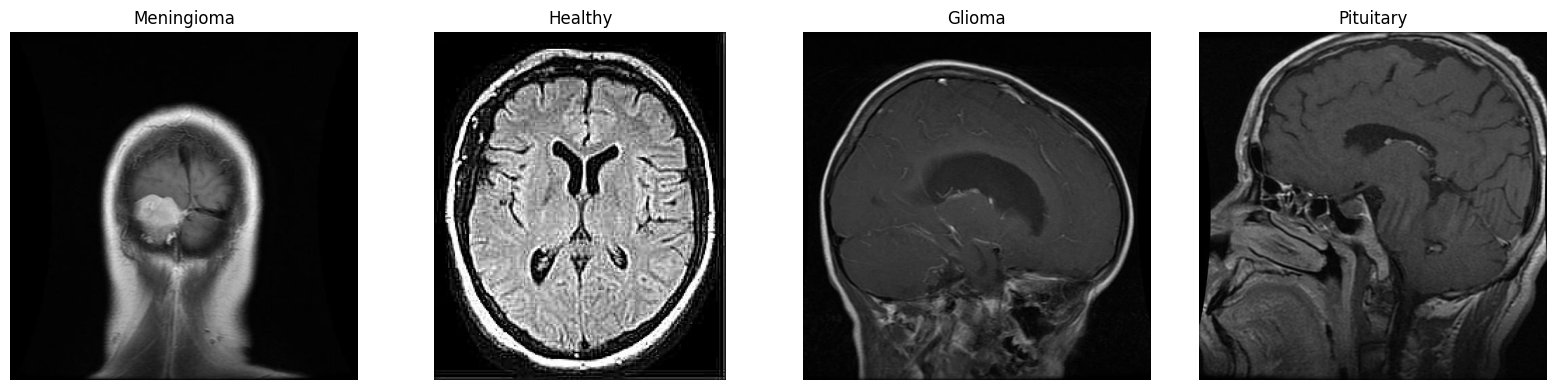

In [4]:
#==========================================================
# DOWNLOAD DATASET
#==========================================================
def download_mri_data(base_dir:str):

  files.upload() #APIKey de Kaggle

  !mkdir -p ~/.kaggle
  !mv kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

  # Descargar el dataset
  !mkdir -p /content/mri_data
  !kaggle datasets download -d rm1000/brain-tumor-mri-scans -p /content/mri_data --unzip

  # Listar categorías
  categories = os.listdir(base_dir)
  print("Categorías encontradas:", categories)

  # Contar imágenes por clase
  for c in categories:
      path = os.path.join(base_dir, c)
      print(f"{c}: {len(os.listdir(path))} imágenes")

  fig, axes = plt.subplots(1, 4, figsize=(16, 4))
  for i, c in enumerate(categories):
      folder = os.path.join(base_dir, c)
      img_name = random.choice(os.listdir(folder))
      img_path = os.path.join(folder, img_name)
      img = cv2.imread(img_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      axes[i].imshow(img)
      axes[i].set_title(c.capitalize())
      axes[i].axis('off')

  plt.tight_layout()
  plt.show()

#Descarga el conjunto de datos
download_mri_data(base_dir)

In [5]:
#==========================================================
# IMAGE SIZE SCANNER
#==========================================================

def get_images_size(base_dir:str):

  all_sizes = []  # guardamos (ancho, alto)
  per_class_count = {}

  for cls in os.listdir(base_dir):
      cls_path = os.path.join(base_dir, cls)
      if not os.path.isdir(cls_path):
          continue

      imgs = os.listdir(cls_path)
      per_class_count[cls] = len(imgs)

      # vamos a mirar hasta 20 imágenes por clase (para no leer miles)
      for img_name in imgs[:20]:
          img_path = os.path.join(cls_path, img_name)
          img = cv2.imread(img_path)  # esto lee en BGR
          if img is None:
              # a veces hay archivos raros tipo .txt o corruptos
              continue
          h, w, ch = img.shape  # alto, ancho, canales
          all_sizes.append((w, h, ch))


  print("\nEjemplos de tamaños (ancho x alto x canales) en las primeras imágenes revisadas:")
  for s in all_sizes[:10]:
      print(" ", s)

  # estadísticas más globales
  widths = [s[0] for s in all_sizes]
  heights = [s[1] for s in all_sizes]
  channels = [s[2] for s in all_sizes]

  print("\nEstadísticas:")
  print(f"  Ancho min / max / promedio: {min(widths)} / {max(widths)} / {np.mean(widths):.1f}")
  print(f"  Alto  min / max / promedio: {min(heights)} / {max(heights)} / {np.mean(heights):.1f}")

  print("\nCanales más comunes (1=gris, 3=RGB):")
  print(Counter(channels))

#Obtiene el tamaño de las imágenes
get_images_size(base_dir)


Ejemplos de tamaños (ancho x alto x canales) en las primeras imágenes revisadas:
  (512, 512, 3)
  (512, 512, 3)
  (512, 512, 3)
  (512, 512, 3)
  (512, 512, 3)
  (512, 512, 3)
  (512, 512, 3)
  (512, 512, 3)
  (512, 512, 3)
  (512, 512, 3)

Estadísticas:
  Ancho min / max / promedio: 206 / 630 / 461.6
  Alto  min / max / promedio: 214 / 630 / 462.8

Canales más comunes (1=gris, 3=RGB):
Counter({3: 80})


In [6]:
# ==========================================================
# TRAIN-VAL-TEST DIVISION (70-20-10)
# ==========================================================

def traint_val_test_split(base_dir:str, split_dir:str):
    # Crear carpetas destino
    for split in ['train', 'val', 'test']:
        for cls in os.listdir(base_dir):
            os.makedirs(os.path.join(split_dir, split, cls), exist_ok=True)

    # Ratios
    train_ratio = 0.7
    val_ratio = 0.2
    test_ratio = 0.1

    # Procesar cada clase
    for cls in os.listdir(base_dir):
        cls_path = os.path.join(base_dir, cls)
        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png','.jpg','.jpeg'))]

        # Dividir train / val / test
        train_files, temp_files = train_test_split(images, test_size=(1-train_ratio), random_state=seed)
        val_size = val_ratio / (val_ratio + test_ratio)
        val_files, test_files = train_test_split(temp_files, test_size=(1-val_size), random_state=seed)

        # Copiar archivos
        for fname in train_files:
            shutil.copy(os.path.join(cls_path, fname), os.path.join(split_dir, 'train', cls, fname))
        for fname in val_files:
            shutil.copy(os.path.join(cls_path, fname), os.path.join(split_dir, 'val', cls, fname))
        for fname in test_files:
            shutil.copy(os.path.join(cls_path, fname), os.path.join(split_dir, 'test', cls, fname))

    print("División completada con semilla =", seed)
    print("Estructura creada en:", split_dir)

    for split in ['train', 'val', 'test']:
        print(f"\n * {split.upper()}")
        for cls in os.listdir(os.path.join(split_dir, split)):
            count = len(os.listdir(os.path.join(split_dir, split, cls)))
            print(f"  {cls}: {count} imágenes")


# Ejecutar división solo una vez
traint_val_test_split(base_dir, split_dir)

# ==========================================================
# CARGA DE LOS DATASETS
# ==========================================================
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    f"{split_dir}/train",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    f"{split_dir}/val",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)

test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    f"{split_dir}/test",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    seed=seed
)

AUTOTUNE = tf.data.AUTOTUNE

def prepare_dataset(ds, shuffle=False):
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = prepare_dataset(train_ds_raw, shuffle=True)
val_ds   = prepare_dataset(val_ds_raw)
test_ds  = prepare_dataset(test_ds_raw)

print("Datasets listos y optimizados para entrenamiento.")

División completada con semilla = 0
Estructura creada en: /content/mri_data_split

 * TRAIN
  meningioma: 1151 imágenes
  healthy: 1399 imágenes
  glioma: 1134 imágenes
  pituitary: 1229 imágenes

 * VAL
  meningioma: 329 imágenes
  healthy: 400 imágenes
  glioma: 324 imágenes
  pituitary: 351 imágenes

 * TEST
  meningioma: 165 imágenes
  healthy: 201 imágenes
  glioma: 163 imágenes
  pituitary: 177 imágenes
Found 4913 files belonging to 4 classes.
Found 1404 files belonging to 4 classes.
Found 706 files belonging to 4 classes.


Found 4913 files belonging to 4 classes.
Clases detectadas: ['glioma', 'healthy', 'meningioma', 'pituitary']

Mapeo de etiquetas:
0 → glioma
1 → healthy
2 → meningioma
3 → pituitary

 Data augmentation aplicada al conjunto de entrenamiento.


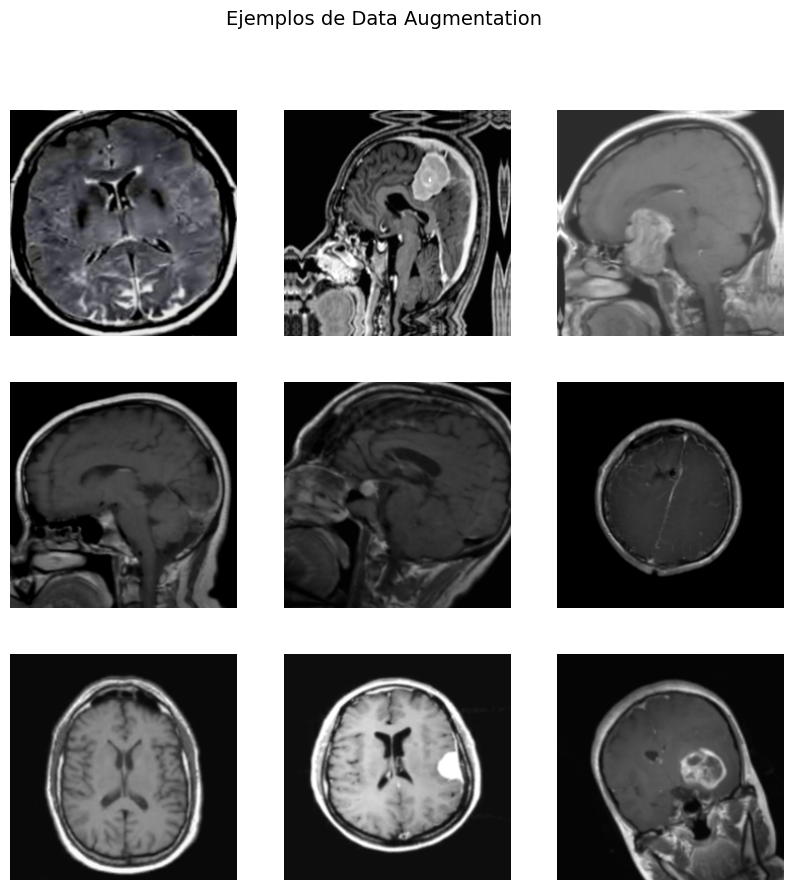

In [7]:
# ==========================================================
# TRAIN DATA AUGMENTATION
# ==========================================================

def data_augmentation(split_dir:str, seed:int, batch_size:int, image_size:tuple):
    # Cargar imágenes (se necesita tamaño fijo)
    train_ds = tf.keras.utils.image_dataset_from_directory(
        f'{split_dir}/train',
        batch_size=batch_size,
        shuffle=True,
        seed=seed,
        image_size=image_size
    )

    class_names = train_ds.class_names
    print("Clases detectadas:", class_names)

    # 🔹 Crear mapeo explícito de índice → nombre
    label_map = {i: name for i, name in enumerate(class_names)}
    print("\nMapeo de etiquetas:")
    for key, value in label_map.items():
        print(f"{key} → {value}")

    # Definir Data Augmentation
    data_augmentation = tf.keras.Sequential([
        RandomRotation(0.05),
        RandomZoom(0.1),
        RandomContrast(0.1),
        RandomBrightness(0.1),
    ])

    # Aplicar aumentación
    train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

    print("\n Data augmentation aplicada al conjunto de entrenamiento.")
    return train_ds, data_augmentation, class_names, label_map


def plot_data_augmentation(train_ds, data_augmentation):
    for images, labels in train_ds.take(1):
        plt.figure(figsize=(10, 10))
        for i in range(9):
            augmented = data_augmentation(images, training=True)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented[i].numpy().astype("uint8"))
            plt.axis("off")
        plt.suptitle("Ejemplos de Data Augmentation", fontsize=14)
        plt.show()
        break


# Ejecutar data augmentation
train_ds, data_aug, class_names, label_map = data_augmentation(split_dir, seed, batch_size, image_size)
plot_data_augmentation(train_ds, data_aug)


Shape de las imágenes: (128, 224, 224, 3)


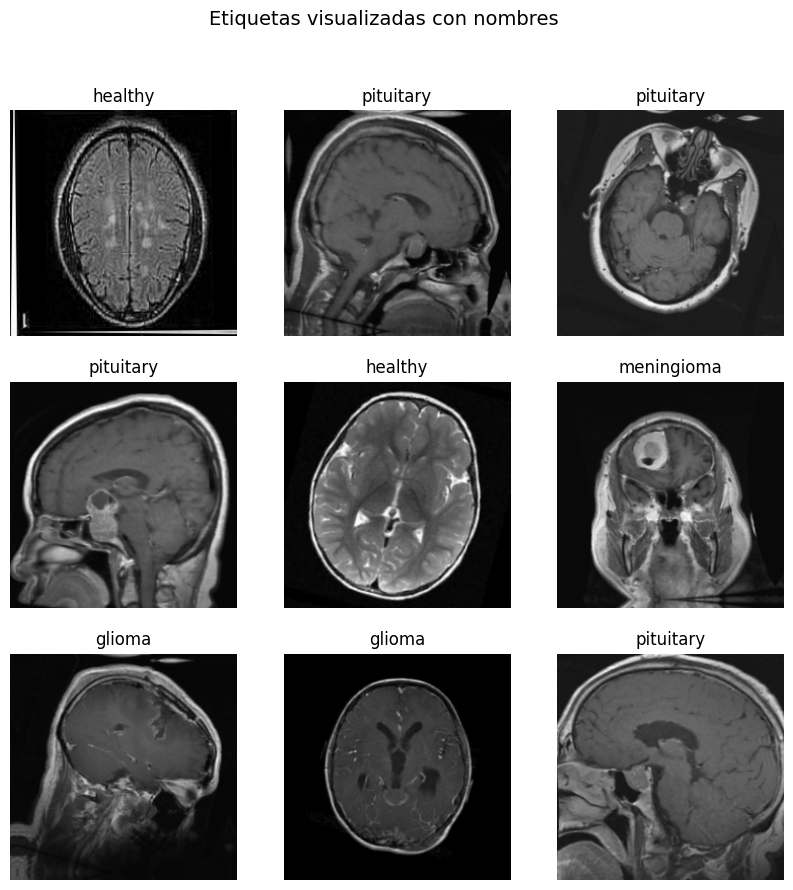

Batch shape: (128, 224, 224, 3)
Labels shape: (128,)


In [8]:
# ==========================================================
# TRAIN LABEL VERIFICATION
# ==========================================================

def get_label(train_ds, class_names, label_map):

    # Mostrar forma y etiquetas del primer batch
    for images, labels in train_ds.take(1):
        print("\nShape de las imágenes:", images.shape)

        # Mostrar 9 imágenes con sus nombres de clase
        plt.figure(figsize=(10, 10))
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label_idx = labels[i].numpy()
            plt.title(label_map[label_idx])
            plt.axis("off")
        plt.suptitle("Etiquetas visualizadas con nombres", fontsize=14)
        plt.show()
        break


# Ejecutar
get_label(train_ds, class_names, label_map)

for images, labels in val_ds.take(1):
    print("Batch shape:", images.shape)
    print("Labels shape:", labels.shape)


In [9]:
# ==========================================================
# CREA EL MODELO
# ==========================================================
def create_model(hp):
    inputs = Input(shape=(None, None, 3))

    # Normalización
    x = Resizing(image_size[0], image_size[1])(inputs)
    x = Rescaling(1./255)(x)

    # ------------------------------------------------------
    # BLOQUE STEM (INICIAL)
    # ------------------------------------------------------
    x = Conv2D(32, 3, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    # ------------------------------------------------------
    # DEFINICIÓN DE BLOQUE MBConv
    # ------------------------------------------------------
    def MBConvBlock(x, filters, expansion, stride, drop_rate):
        in_channels = x.shape[-1]

        # Expansión
        y = Conv2D(filters * expansion, 1, padding='same', use_bias=False)(x)
        y = BatchNormalization()(y)
        y = Activation('swish')(y)

        # Depthwise separable conv
        y = DepthwiseConv2D(3, strides=stride, padding='same', use_bias=False)(y)
        y = BatchNormalization()(y)
        y = Activation('swish')(y)

        # Squeeze & Excitation
        se = GlobalAveragePooling2D()(y)
        se = Reshape((1, 1, filters * expansion))(se)
        se = Conv2D(max(1, filters // 4), 1, activation='swish', padding='same')(se)
        se = Conv2D(filters * expansion, 1, activation='sigmoid', padding='same')(se)
        y = Multiply()([y, se])

        # Proyección
        y = Conv2D(filters, 1, padding='same', use_bias=False)(y)
        y = BatchNormalization()(y)

        # Residual connection (si aplica)
        if stride == 1 and in_channels == filters:
            y = Add()([y, x])

        y = Dropout(drop_rate)(y)
        return y

    # ------------------------------------------------------
    # BLOQUES MBConv (INSPIRADOS EN EFFICIENTNETB0)
    # ------------------------------------------------------
    x = MBConvBlock(x, filters=16, expansion=1, stride=1, drop_rate=0.1)
    x = MBConvBlock(x, filters=24, expansion=6, stride=2, drop_rate=0.1)
    x = MBConvBlock(x, filters=24, expansion=6, stride=1, drop_rate=0.1)
    x = MBConvBlock(x, filters=40, expansion=6, stride=2, drop_rate=0.2)
    x = MBConvBlock(x, filters=80, expansion=6, stride=2, drop_rate=0.2)
    x = MBConvBlock(x, filters=112, expansion=6, stride=1, drop_rate=0.3)
    x = MBConvBlock(x, filters=160, expansion=6, stride=2, drop_rate=0.3)

    # ------------------------------------------------------
    # BLOQUE FINAL (HEAD)
    # ------------------------------------------------------
    x = GlobalAveragePooling2D()(x)
    x = Dense(
        units=hp.Choice('dense_units', [128, 192, 256]),
        activation='swish'
    )(x)
    x = BatchNormalization()(x)
    x = Dropout(hp.Choice('dropout_1', [0.4, 0.5]))(x)
    outputs = Dense(4, activation='softmax', dtype='float32')(x)

    # Crear modelo
    model = Model(inputs, outputs, name="efficientnet_mri_model")

    # ------------------------------------------------------
    # COMPILACIÓN
    # ------------------------------------------------------
    lr = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])
    optimizer = AdamW(learning_rate=lr, weight_decay=1e-5)
    loss = SparseCategoricalCrossentropy()

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

# ==========================================================
# BUSQUEDA DE HIPERPARÁMETROS
# ==========================================================
tuner = RandomSearch(
    create_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuning_results',
    project_name='cnn_mri_tuning_v2'
)

# ==========================================================
# ENTRENAMIENTO DEL MODELO BASE
# ==========================================================
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1
)

# ==========================================================
# MEJOR MODELO
# ==========================================================
tuner.results_summary()
best_model = tuner.get_best_models(num_models=1)[0]


Trial 5 Complete [00h 14m 12s]
val_accuracy: 0.23433049023151398

Best val_accuracy So Far: 0.23433049023151398
Total elapsed time: 01h 12m 50s
Results summary
Results in tuning_results/cnn_mri_tuning_v2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
dense_units: 128
dropout_1: 0.4
learning_rate: 0.001
Score: 0.23433049023151398

Trial 1 summary
Hyperparameters:
dense_units: 192
dropout_1: 0.4
learning_rate: 0.001
Score: 0.23433049023151398

Trial 2 summary
Hyperparameters:
dense_units: 192
dropout_1: 0.5
learning_rate: 0.001
Score: 0.23433049023151398

Trial 3 summary
Hyperparameters:
dense_units: 192
dropout_1: 0.5
learning_rate: 0.0005
Score: 0.23433049023151398

Trial 4 summary
Hyperparameters:
dense_units: 192
dropout_1: 0.5
learning_rate: 0.0001
Score: 0.23433049023151398


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 202 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [10]:
#Resumen
best_model.summary()

Model: "efficientnet_mri_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing (Resizing) │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ resizing[0][0]    │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │        864 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │        512 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 112, 112,  │        144 │ activation_1[0][… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         64 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ activation_2[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 16)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 1, 1, 4)   │         68 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 1, 1, 16)  │         80 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 112, 112,  │          0 │ activation_2[0][… │
│                     │ 16)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 112, 112,  │        256 │ multiply[0][0]  

 Total params: 690,934 (2.64 MB)

 Trainable params: 679,078 (2.59 MB)

 Non-trainable params: 11,856 (46.31 KB)

In [11]:
#Hiperparámetros del mejor modelo base
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Mejores hiperparámetros encontrados:")
for key, value in best_hps.values.items():
    print(f" - {key}: {value}")

Mejores hiperparámetros encontrados:
 - dense_units: 128
 - dropout_1: 0.4
 - learning_rate: 0.001


In [12]:
# ==========================================================
# MEJORA MODELO BASE
# ==========================================================

# Detiene el entrenamiento si no mejora la val_loss
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

# Reduce el learning rate si la validación deja de mejorar
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Guarda el mejor modelo durante el entrenamiento
checkpoint = ModelCheckpoint(
    'best_model_v2.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

#Entrenamiento
history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6085 - loss: 0.9752
Epoch 1: val_accuracy improved from -inf to 0.23433, saving model to best_model_v2.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.6091 - loss: 0.9738 - val_accuracy: 0.2343 - val_loss: 1.4227 - learning_rate: 0.0010
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6972 - loss: 0.7827
Epoch 2: val_accuracy did not improve from 0.23433
39/39 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.6975 - loss: 0.7819 - val_accuracy: 0.2343 - val_loss: 1.4577 - learning_rate: 0.0010
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7289 - loss: 0.6629
Epoch 3: val_accuracy did not improve from 0.23433
39/39 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.7294 - loss: 0.6622 - val_accuracy: 0.2343 - val_loss: 1.5093 - learning_rate: 0.0010
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7723 - loss: 0.5698
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005

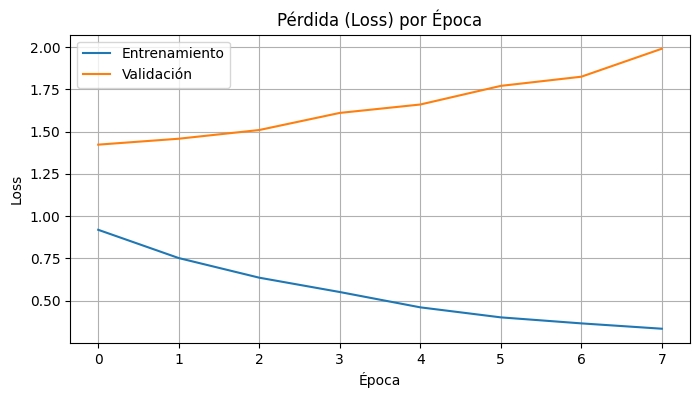

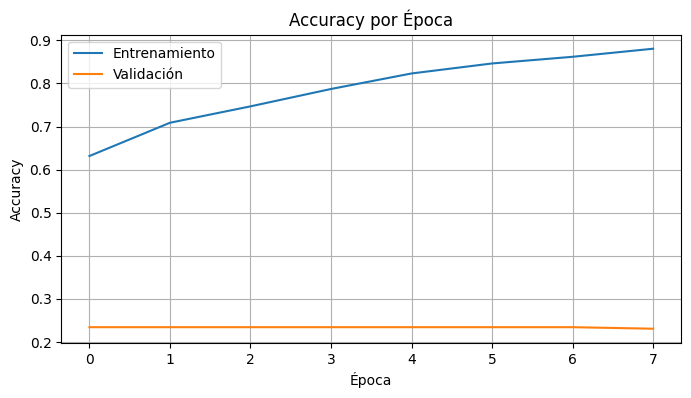

In [13]:
# Curva de pérdida
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida (Loss) por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
#plt.ylim(0, 0.7)
plt.grid(True)
plt.show()


# Curva de accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Accuracy por Época')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
#plt.ylim(0.8, 1.0)
plt.grid(True)
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.2391 - loss: 1.4265

Accuracy en test: 0.2337
Pérdida (Loss) en test: 1.4231
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 809ms/step

Reporte de clasificación:

              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       163
     healthy       0.00      0.00      0.00       201
  meningioma       0.23      1.00      0.38       165
   pituitary       0.00      0.00      0.00       177

    accuracy                           0.23       706
   macro avg       0.06      0.25      0.09       706
weighted avg       0.05      0.23      0.09       706



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


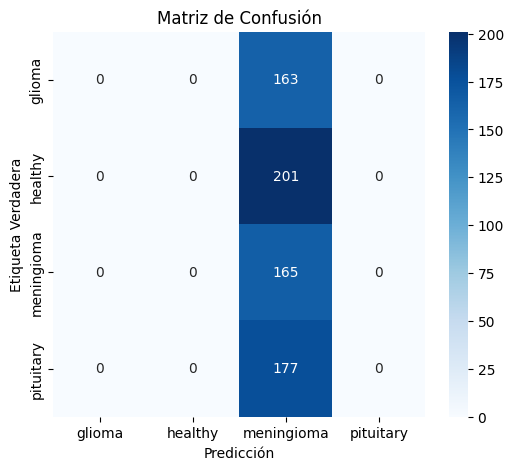

In [14]:
# ==========================================================
# EVALUACIÓN DEL MODELO
# ==========================================================

# Evaluar desempeño global
test_loss, test_acc = best_model.evaluate(test_ds)
print(f"\nAccuracy en test: {test_acc:.4f}")
print(f"Pérdida (Loss) en test: {test_loss:.4f}")

# Obtener predicciones
y_pred_probs = best_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtener etiquetas reales
y_true = np.concatenate([y for x, y in test_ds], axis=0)

print("\nReporte de clasificación:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Verdadera")
plt.show()

In [15]:
auc_score = roc_auc_score(
    tf.one_hot(y_true, depth=len(class_names)),
    y_pred_probs,
    multi_class='ovr'
)
print(f"🔹 AUC promedio (One-vs-Rest): {auc_score:.4f}")

🔹 AUC promedio (One-vs-Rest): 0.4898
